Notebook based on _Hands-On Graph Neural Networks Using Python_, by Maxime Labonne.

# Ch 6. Introducing Graph Convolutional Networks

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
from scipy.stats import norm
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.utils import degree

## 6.1 Introduction

We return to the node embedding calculation from chapter 5:

$$
H = \tilde{A}^T X W^T
$$

We noted that there is no normalization here, which means that nodes with a large number of neighbors will generally have higher embedding values. This makes it harder to compare embeddings.

We can fix this problem by normalizing the adjacency matrix. There are at least a couple different ways to do this. We'll cover both.

### 6.1.1 Asymmetric normalization

The first approach is called  _asymmetric normalization_. Here we normalize each row to sum to 1 unit by dividing each row element by the node degree. The result is a _stochastic transition matrix_ &mdash; that is, it is the transition matrix of a Markov chain.

This type of normalization is called _asymmetric_ because the normalized adjacency matrix is asymmetric.

Let's work with a concrete example.

In [2]:
# Adjacency matrix
A = np.array([
    [0, 1, 1, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
])
A

array([[0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0]])

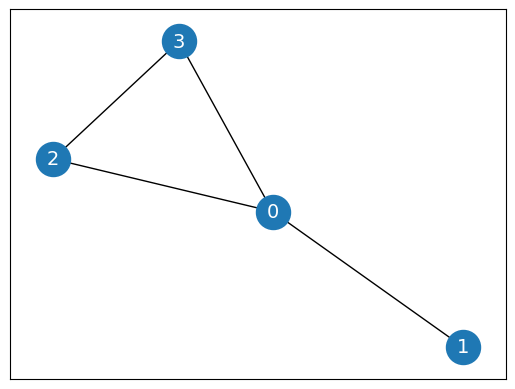

In [3]:
graph = nx.from_numpy_array(A)
nx.draw_networkx(
    graph,
    pos=nx.spring_layout(graph, seed=0),
    node_size=600,
    font_size=14,
    font_color='white')

In [4]:
nodes = list(graph.nodes())
degrees = np.array([graph.degree(n) for n in nodes])
D = np.diag(degrees)
D  # degree matrix

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]])

In [5]:
# Add self-loops (see ch 5)
A_adj = A + np.identity(len(A))
D_adj = D + np.identity(len(D))
D_adj_inv = np.linalg.inv(D_adj)
D_adj_inv

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [6]:
D_adj_inv @ np.transpose(A_adj)

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

This appears to be a promising replacement for the unnormalized adjacency matrix, but there is an even better approach.

### 6.1.2 Symmetric normalization

Kipf and Welling (see [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)) discovered that features from nodes having lots of neighbors tend to spread easily. They propose an improved approach, called _symmetric normalization_, where they mitigate this issue by assigning higher weights to nodes with fewer neighbors. This type of normalization results in a symmetric matrix:

$$
\tilde{D}^{-\frac{1}{2}} \tilde{A}^T \tilde{D}^{-\frac{1}{2}}
$$

The resulting graph linear layer performs this transformation:

$$
H = \tilde{D}^{-\frac{1}{2}} \tilde{A}^T \tilde{D}^{-\frac{1}{2}} X W^T
$$

In [7]:
D_adj_neg_sqrt = np.linalg.inv(sqrtm(D_adj))
D_adj_neg_sqrt @ np.transpose(A_adj) @ D_adj_neg_sqrt

array([[0.25      , 0.35355339, 0.28867513, 0.28867513],
       [0.35355339, 0.5       , 0.        , 0.        ],
       [0.28867513, 0.        , 0.33333333, 0.33333333],
       [0.28867513, 0.        , 0.33333333, 0.33333333]])

In [8]:
A_adj

array([[1., 1., 1., 1.],
       [1., 1., 0., 0.],
       [1., 0., 1., 1.],
       [1., 0., 1., 1.]])

The GCN linear layer uses symmetric normalization.

## 6.2 Shared code 

In [9]:
def plot_node_degrees(data):
    degrees = degree(data.edge_index[0]).numpy()
    numbers = Counter(degrees)
    fig, ax = plt.subplots()
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(), numbers.values())

## 6.3 GCN classification task

### 6.3.1 GCN classification code

In [10]:
# Simple accuracy measure -- not intended for production use.
# The NNs below use this for training.
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [11]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
            train_loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                train_acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### 6.3.2 Cora dataset GCN

In [12]:
# Note that the Cora data has training, validation and test masks by default, so we
# don't have to set those explicitly here. (Below with the Facebook Page-Page data,
# we will have to do it ourselves.)
cora_ds = Planetoid(root=".", name="Cora")
cora_data = cora_ds[0]

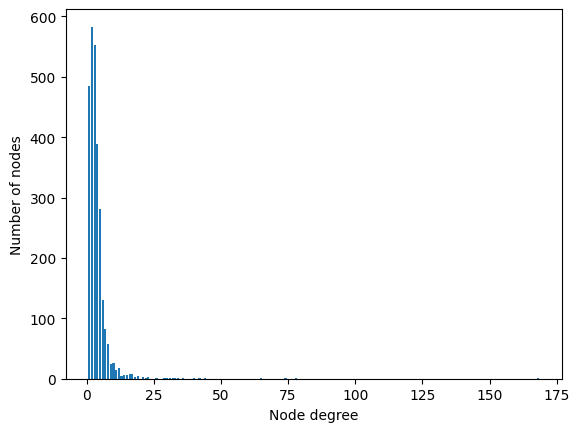

In [13]:
plot_node_degrees(cora_data)

In [14]:
cora_gcn = GCN(cora_ds.num_features, 16, cora_ds.num_classes)
print(cora_gcn)
cora_gcn.fit(cora_data, epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.95 | Train Acc: 13.57% | Val Loss: 1.94 | Val Acc: 12.40%
Epoch  20 | Train Loss: 0.15 | Train Acc: 100.00% | Val Loss: 0.83 | Val Acc: 76.40%
Epoch  40 | Train Loss: 0.02 | Train Acc: 100.00% | Val Loss: 0.78 | Val Acc: 75.60%
Epoch  60 | Train Loss: 0.02 | Train Acc: 100.00% | Val Loss: 0.77 | Val Acc: 76.20%
Epoch  80 | Train Loss: 0.02 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.02 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 77.20%


In [15]:
acc = cora_gcn.test(cora_data)
print(f'\nCora GCN test accuracy: {acc*100:.2f}%')


Cora GCN test accuracy: 79.30%


### 6.3.3 Facebook Page-Page dataset GCN

In [16]:
from torch_geometric.datasets import FacebookPagePage

In [17]:
fb_ds = FacebookPagePage(root="./FacebookPagePage")
fb_data = fb_ds[0]

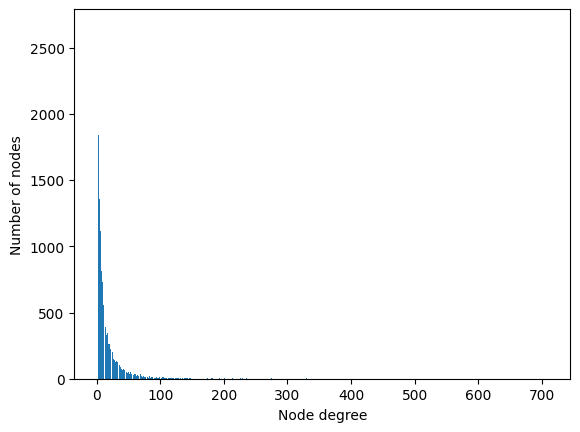

In [18]:
plot_node_degrees(fb_data)

In [19]:
# We have to define these explicitly, because unlike the Cora data, the Facebook
# Page-Page data doesn't come with them.
fb_data.train_mask = range(18000)        # Training
fb_data.val_mask = range(18001, 20000)   # Validation
fb_data.test_mask = range(20001, 22470)  # Test

In [20]:
fb_gcn = GCN(fb_ds.num_features, 16, fb_ds.num_classes)
print(fb_gcn)
fb_gcn.fit(fb_data, epochs=100)

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.51 | Train Acc: 19.96% | Val Loss: 1.51 | Val Acc: 20.01%
Epoch  20 | Train Loss: 0.46 | Train Acc: 84.33% | Val Loss: 0.45 | Val Acc: 84.29%
Epoch  40 | Train Loss: 0.32 | Train Acc: 89.48% | Val Loss: 0.31 | Val Acc: 89.34%
Epoch  60 | Train Loss: 0.28 | Train Acc: 91.31% | Val Loss: 0.28 | Val Acc: 91.05%
Epoch  80 | Train Loss: 0.26 | Train Acc: 92.22% | Val Loss: 0.26 | Val Acc: 92.05%
Epoch 100 | Train Loss: 0.24 | Train Acc: 92.63% | Val Loss: 0.25 | Val Acc: 92.40%


In [21]:
acc = fb_gcn.test(fb_data)
print(f'\nFacebook Page-Page GCN test accuracy: {acc*100:.2f}%')


Facebook Page-Page GCN test accuracy: 91.58%


## 6.4 GCN prediction task

### 6.4.1 Get data

In [22]:
wn_ds = WikipediaNetwork(
    root=".",
    name="chameleon",
    transform=T.RandomNodeSplit(num_val=200, num_test=500)
)
wn_data = wn_ds[0]

### 6.4.2 Prepare data

The original dataset contains classifications, but we want to replace those with numerical labels so we can demonstrate a prediction model.

In [23]:
wn_df = pd.read_csv('./wikipedia/chameleon/musae_chameleon_target.csv')
wn_df

,id,target
0,0,171
1,1,8089
2,2,8568
3,3,47178
4,4,3634
...,...,...
2272,2272,31418
2273,2273,2716
2274,2274,99
2275,2275,22898


In [24]:
# Log targets (numerical).
# These are the values that we're going to predict.
wn_values = np.log10(wn_df['target'])

In [25]:
# Replace dataset classes with log targets
wn_data.y = torch.tensor(wn_values)
wn_data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

In [26]:
# Replace targets with log targets
wn_df['target'] = wn_values
wn_df

,id,target
0,0,2.232996
1,1,3.907895
2,2,3.932879
3,3,4.673740
4,4,3.560385
...,...,...
2272,2272,4.497179
2273,2273,3.433930
2274,2274,1.995635
2275,2275,4.359798


### 6.4.3 Exploratory data analysis

In [27]:
def summarize_dataset(dataset):
    data = dataset[0]
    
    print(f'Dataset: {dataset}')
    print('--------------------')
    print(f'# graphs   : {len(dataset)}')
    print(f'# nodes    : {data.x.shape[0]}')
    print(f'# features : {dataset.num_features}')
    print(f'# classes  : {dataset.num_classes} (not relevant here)')
    print('')
    print(f'Graph:')
    print('--------------------')
    print(f'Edges are directed       : {data.is_directed()}')
    print(f'Graph has isolated nodes : {data.has_isolated_nodes()}')
    print(f'Graph has loops          : {data.has_self_loops()}')

In [28]:
summarize_dataset(wn_ds)

Dataset: WikipediaNetwork()
--------------------
# graphs   : 1
# nodes    : 2277
# features : 2325
# classes  : 5 (not relevant here)

Graph:
--------------------
Edges are directed       : True
Graph has isolated nodes : False
Graph has loops          : True


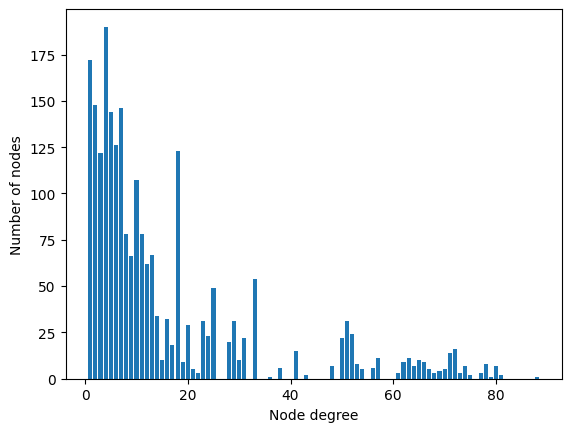

In [29]:
plot_node_degrees(wn_data)

<Axes: xlabel='target', ylabel='Density'>

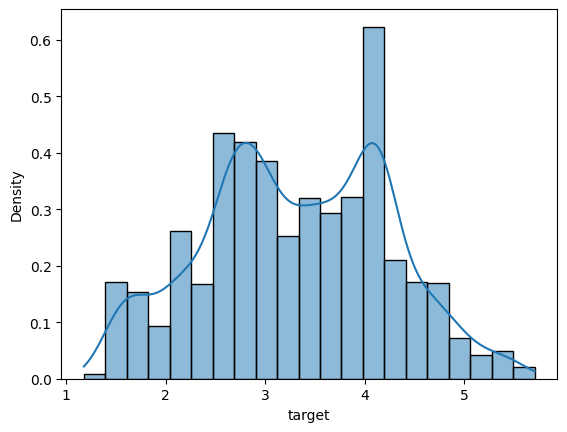

In [30]:
sns.histplot(wn_df['target'], kde=True, stat='density')

### 6.4.4 GCN prediction code

In [31]:
class GCN_Prediction(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        # Encoder architecture -- decreasing number of neurons.
        # Forces dimensionality reduction.
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        # No log softmax since this isn't a classifier
        return h

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            train_loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            train_loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                # Tensor.squeeze() removes all dimensions of size 1
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}')

    # torch.no_grad() disabled gradient computation.
    # Useful for inference, as it reduces memory usage and speeds up computations.
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

In [32]:
wn_gcn = GCN_Prediction(wn_ds.num_features, 128, 1)
print(wn_gcn)
wn_gcn.fit(wn_data, epochs=200)

GCN_Prediction(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 11.97142 | Val Loss: 11.54305
Epoch  20 | Train Loss: 11.86660 | Val Loss: 11.40375
Epoch  40 | Train Loss: 7.53288 | Val Loss: 7.39628
Epoch  60 | Train Loss: 1.98999 | Val Loss: 2.07095
Epoch  80 | Train Loss: 0.72950 | Val Loss: 0.78506
Epoch 100 | Train Loss: 0.61536 | Val Loss: 0.73006
Epoch 120 | Train Loss: 0.52792 | Val Loss: 0.79654
Epoch 140 | Train Loss: 0.51987 | Val Loss: 0.80102
Epoch 160 | Train Loss: 0.44888 | Val Loss: 0.77767
Epoch 180 | Train Loss: 0.44034 | Val Loss: 0.69127
Epoch 200 | Train Loss: 0.42020 | Val Loss: 0.67048


In [33]:
wn_loss = wn_gcn.test(wn_data)
print(f'GCN test loss: {wn_loss:.5f}')

GCN test loss: 0.76690


In [34]:
out = wn_gcn(wn_data.x, wn_data.edge_index)
y_pred = out.squeeze()[wn_data.test_mask].detach().numpy()
mse = mean_squared_error(wn_data.y[wn_data.test_mask], y_pred)
mae = mean_absolute_error(wn_data.y[wn_data.test_mask], y_pred)

In [35]:
print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7669 | RMSE = 0.8757 | MAE = 0.6837


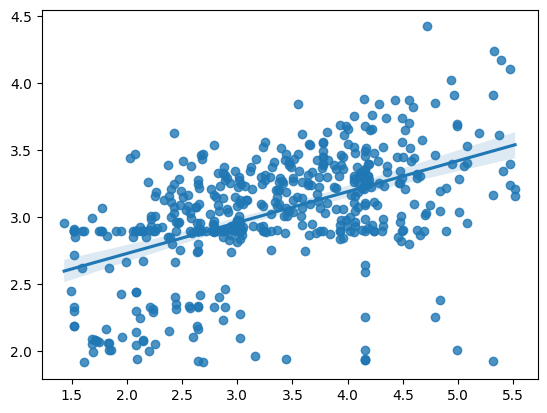

In [36]:
fig = sns.regplot(x=wn_data.y[wn_data.test_mask].numpy(), y=y_pred)

## 6.5 Further reading and resources

- [Spectral Networks and Locally Connected Networks on Graphs](https://arxiv.org/abs/1312.6203)
- [Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering](https://arxiv.org/abs/1606.09375)
- [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)
- [SNAP: Network datasets: Wikipedia Article Networks](https://snap.stanford.edu/data/wikipedia-article-networks.html)